### Import librairies

In [1]:
# Main libraries
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

# Libraries for vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Show exact values on barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Code to display all columns and all texts
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 100
    display.max_rows = 100
    display.max_colwidth = 300
    display.width = None
set_pandas_display_options()

### Import pre-processed dataset

In [3]:
train_df_nan40 = pd.read_csv('train_df_nan40.csv')

In [4]:
# remove special characters in train_df_nan40 feature names
train_df_nan40.columns = train_df_nan40.columns.str.replace(':', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace(',', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace(']', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('[', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('{', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('}', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('"', '')

# Create and evaluate classification models

### Evaluate DummyClassifier

In [4]:
# Import necessary functions
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [5]:
# Create X (features matrix) and y (Target) from train_df_nan40
X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], 1)
y = train_df_nan40.TARGET

In [6]:
# Create DummyClassifier with 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy = 'most_frequent')
# Define cross validation strategy
cv = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
# Define scoring strategy
scoring = ('accuracy', 'f1_weighted', 'roc_auc')
# Evaluate accuracy, AUC and f1 scores after cross validation
scores = cross_validate(dummy_clf, 
                        X, y, 
                        cv = cv,
                        scoring = scoring)

# Print test scores and mean scores for each metric
list_scoring = ['test_accuracy', 'test_f1_weighted', 'test_roc_auc']
for score in list_scoring:
    print(f'{score} scores')
    print(scores[score])
    print(f'{score} mean score')
    print(round(scores[score].mean(), 3))
    print('------------')

test_accuracy scores
[0.91927092 0.91927092 0.91926961 0.91926961 0.91926961]
test_accuracy mean score
0.919
------------
test_f1_weighted scores
[0.88060421 0.88060421 0.88060229 0.88060229 0.88060229]
test_f1_weighted mean score
0.881
------------
test_roc_auc scores
[0.5 0.5 0.5 0.5 0.5]
test_roc_auc mean score
0.5
------------


-> accuracy mean score = 0.919 just means that the majority class represents 91.9% of the whole dataset
-> roc_auc mean score = 0.5 corresponds to the score of a random classifier

In [7]:
# Create DummyClassifier with 'stratified' strategy
dummy_clf = DummyClassifier(strategy = 'stratified')
# Define cv strategy
cv = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
# Define scoring strategy
scoring = ('accuracy', 'f1_weighted', 'roc_auc')
# Evaluate accuracy, AUC and f1 scores after cross validation
scores = cross_validate(dummy_clf, 
                        X, y, 
                        cv = cv,
                        scoring = scoring)

# Print test scores and mean scores for each metric
list_scoring = ['test_accuracy', 'test_f1_weighted', 'test_roc_auc']
for score in list_scoring:
    print(f'{score} scores')
    print(scores[score])
    print(f'{score} mean score')
    print(round(scores[score].mean(), 3))
    print('------------')

test_accuracy scores
[0.85115931 0.85161458 0.85250646 0.85109185 0.85060406]
test_accuracy mean score
0.851
------------
test_f1_weighted scores
[0.85089843 0.85140943 0.8526484  0.85114652 0.85091809]
test_f1_weighted mean score
0.851
------------
test_roc_auc scores
[0.49866435 0.4998129  0.49772107 0.49811847 0.49834925]
test_roc_auc mean score
0.499
------------


-> roc_auc mean score = 0.499 corresponds to the score of a random classifier

-> Other classifiers will be evaluated using roc_auc scores

### SGDClassifier

In [8]:
# SGD Classifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', SGDClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_sgdc_default = GridSearchCV(estimator = pipeline,
                               param_grid = param_grid,
                               scoring = 'roc_auc',
                               cv = stratified_kfold,
                               verbose = 5,
                               return_train_score = True)


gs_sgdc_default.fit(X, y)

cv_score_sgdc_default = gs_sgdc_default.best_score_
print('cv_score_sgdc_default:', cv_score_sgdc_default)

cv_results_sgdc_default = gs_sgdc_default.cv_results_
df_sgdc_default = pd.DataFrame(cv_results_sgdc_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.663, test=0.658) total time= 1.3min
[CV 2/5] END ..............., score=(train=0.672, test=0.667) total time=  22.5s
[CV 3/5] END ..............., score=(train=0.671, test=0.674) total time=  26.2s
[CV 4/5] END ..............., score=(train=0.669, test=0.664) total time=  21.1s
[CV 5/5] END ..............., score=(train=0.659, test=0.664) total time=  23.2s
cv_score_lgbm: 0.665507676587798
Execution time in seconds: 206.40424728393555
Execution time in minutes: 3.4400707880655923


In [12]:
# SGD Classifier with scaler/classifier pipeline (no oversampling)
# Testing parameters with gridsearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', SGDClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different parameters
param_grid = {'classifier__alpha': [1e-4, 1e-2, 1e0, 1e2], # learning rate
              'classifier__max_iter': [1000], # number of epochs,
              'classifier__loss': ['hinge', 'log'], # linear SVM or logistic regression,
              'classifier__penalty': ['l2']}

gs_sgdc = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)


gs_sgdc.fit(X, y)

cv_score_sgdc = gs_sgdc.best_score_
print('cv_score_sgdc:', cv_score_sgdc)

cv_results_sgdc = gs_sgdc.cv_results_
df_sgdc = pd.DataFrame(cv_results_sgdc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.645, test=0.646) total time=  22.9s
[CV 2/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.688, test=0.686) total time=  33.3s
[CV 3/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.667, test=0.664) total time=  20.5s
[CV 4/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.658, test=0.650) total time=  21.4s
[CV 5/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.657, test=0.654) total time=  18.1s
[CV 1/5] END classifier__alpha=0.0001, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2

In [14]:
# Compare loss params : hinge (linearSVM) and log(logistic regression)
df_sgdc.groupby('param_classifier__loss')['mean_test_score'].mean()

param_classifier__loss
hinge    0.693008
log      0.733115
Name: mean_test_score, dtype: float64

-> Logistic regression results in better roc_auc scores

In [19]:
# Sort results by mean_test_score in df_sgdc
df_sgdc.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,"{'classifier__alpha': 0.01, 'classifier__loss'...",0.764517,...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390
1,19.686957,3.812885,0.418668,0.075504,0.0001,log,1000,l2,"{'classifier__alpha': 0.0001, 'classifier__los...",0.751428,...,0.744100,0.003717,2,0.756864,0.745054,0.746666,0.745915,0.751584,0.749217,0.004446
5,8.295024,0.453398,0.622081,0.214608,1.0,log,1000,l2,"{'classifier__alpha': 1.0, 'classifier__loss':...",0.720581,...,0.722398,0.001533,3,0.721814,0.722815,0.722291,0.724871,0.727825,0.723923,0.002212
4,14.970112,4.955132,0.694214,0.303806,1.0,hinge,1000,l2,"{'classifier__alpha': 1.0, 'classifier__loss':...",0.754995,...,0.720236,0.018813,4,0.760214,0.708963,0.708457,0.704915,0.729412,0.722392,0.020783
7,7.162304,0.242792,0.402341,0.059074,100.0,log,1000,l2,"{'classifier__alpha': 100.0, 'classifier__loss...",0.703053,...,0.702599,0.001612,5,0.703664,0.703395,0.703431,0.703678,0.704082,0.703650,0.000245
6,12.366454,2.819907,0.828855,0.732299,100.0,hinge,1000,l2,"{'classifier__alpha': 100.0, 'classifier__loss...",0.702055,...,0.701638,0.001611,6,0.702657,0.702442,0.702441,0.702716,0.703096,0.702671,0.000240
2,24.294172,14.536203,0.524458,0.195153,0.01,hinge,1000,l2,"{'classifier__alpha': 0.01, 'classifier__loss'...",0.688977,...,0.690103,0.033700,7,0.691822,0.759005,0.682961,0.666758,0.667529,0.693615,0.034042
0,21.766879,3.293911,1.579971,2.132744,0.0001,hinge,1000,l2,"{'classifier__alpha': 0.0001, 'classifier__los...",0.646323,...,0.660054,0.014147,8,0.644515,0.688343,0.667357,0.658472,0.657350,0.663207,0.014527


In [16]:
# Print the best parameters
gs_sgdc.best_params_

{'classifier__alpha': 0.01,
 'classifier__loss': 'log',
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2'}

-> Those parameters will be used with SMOTE oversampling in the pipeline

In [43]:
# SGD Classifier with smote/scaler/classifier pipeline (oversampling)
# Testing smote parameters with gridsearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', SGDClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different parameters
param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__alpha': [1e-2], # learning rate
              'classifier__max_iter': [1000], # number of epochs,
              'classifier__loss': ['log'], # linear SVM or logistic regression,
              'classifier__penalty': ['l2']}

gs_sgdc_smote = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)

gs_sgdc_smote.fit(X, y)

cv_score_sgdc_smote = gs_sgdc_smote.best_score_
print('cv_score_sgdc_smote:', cv_score_sgdc_smote)

cv_results_sgdc_smote = gs_sgdc_smote.cv_results_
df_sgdc_smote = pd.DataFrame(cv_results_sgdc_smote)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.751) total time=  36.0s
[CV 2/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.753) total time=  36.8s
[CV 3/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.752) total time=  35.2s
[CV 4/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.756, test=0.749) total time=  33.9s
[CV 5/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.757, test=0

In [44]:
# Sort results by mean_test_score in df_sgdc_smote
df_sgdc_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012


In [45]:
# Keep only best results in df_sgdc
df_sgdc_best_results = df_sgdc.sort_values(by = 'mean_test_score', ascending = False).head(1)

# Concatenate df_sgdc_smote with best results in df_sgdc (without smote)
df_sgdc_smote = pd.concat([df_sgdc_smote, df_sgdc_best_results], axis = 0)

In [46]:
# Sort by 'mean_test_score'
df_sgdc_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,NaN,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012


In [47]:
df_sgdc_smote['param_smote__sampling_strategy'] = df_sgdc_smote['param_smote__sampling_strategy'].fillna('None')

In [48]:
df_sgdc_smote

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,None,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390


In [15]:
# Plot mean test scores by param_smote__sampling_strategy
import seaborn as sns

plt.figure(figsize=(9, 6))

sns.set_theme(style="whitegrid")

g = sns.barplot(x = 'param_smote__sampling_strategy',
                y = 'mean_test_score',
                data = df_sgdc_smote,
                order = ['None', 0.25, 0.5, 1])

# Show exact mean_test_score for each sampling strategy
for i in g.containers:
    g.bar_label(i,)

plt.title('mean test scores by smote sampling strategy after cross-validated SGDClassifier')

plt.show()

NameError: name 'df_sgdc_smote' is not defined

<Figure size 648x432 with 0 Axes>

### Conclusions for SGD Classifier
- best parameters found by GridSearchCV are alpha = 0.01 and loss = log
- oversampling the minority class with SMOTE disimproves the mean test scores

### Logistic Regression

In [57]:
# Logistic Regression with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_lr_default = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)


gs_lr_default.fit(X, y)

cv_score_lr_default = gs_lr_default.best_score_
print('cv_score_lr_default:', cv_score_lr_default)

cv_results_lr_default = gs_lr_default.cv_results_
df_lr_default = pd.DataFrame(cv_results_lr_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.773, test=0.768) total time=  41.0s
[CV 2/5] END ..............., score=(train=0.773, test=0.769) total time=  43.9s
[CV 3/5] END ..............., score=(train=0.773, test=0.768) total time=  34.2s
[CV 4/5] END ..............., score=(train=0.773, test=0.766) total time=  31.7s
[CV 5/5] END ..............., score=(train=0.773, test=0.765) total time=  29.6s
cv_score_lr_default: 0.7671036824949046
Execution time in seconds: 239.43307614326477
Execution time in minutes: 3.990551269054413


In [6]:
# Logistic Regression with scaler/classifier pipeline (no oversampling)
# Testing different parameters with gridsearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different parameters
param_grid = {'classifier__penalty': ['l2'],
              'classifier__C': [0.01, 0.1, 1, 10, 100],
              'classifier__solver': ['lbfgs']}

gs_lr = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)


gs_lr.fit(X, y)

cv_score_lr = gs_lr.best_score_
print('cv_score_lr:', cv_score_lr)

cv_results_lr = gs_lr.cv_results_
df_lr = pd.DataFrame(cv_results_lr)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.772, test=0.767) total time=  35.0s
[CV 2/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.772, test=0.768) total time=  26.1s
[CV 3/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.772, test=0.768) total time=  28.0s
[CV 4/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.773, test=0.766) total time=  31.4s
[CV 5/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.773, test=0.765) total time=  30.6s
[CV 1/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.773, test=0.768) total time=  31.9s
[CV 2/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.773, test=0.769) total time=  26.

In [7]:
# Sort results by mean_test_score in df_lr
df_lr.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,26.013367,2.849105,0.454668,0.069561,0.1,l2,lbfgs,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767891,0.768547,...,0.767124,0.001298,1,0.772697,0.772503,0.772916,0.773151,0.773504,0.772954,0.000350
2,27.110280,0.883060,0.806925,0.687904,1,l2,lbfgs,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.768064,0.768608,...,0.767104,0.001375,2,0.772841,0.772578,0.772928,0.773121,0.773483,0.772990,0.000302
4,27.466483,1.472623,0.466294,0.070657,100,l2,lbfgs,"{'classifier__C': 100, 'classifier__penalty': ...",0.768000,0.768541,...,0.767084,0.001343,3,0.772775,0.772621,0.772866,0.773119,0.773488,0.772974,0.000304
3,27.356879,2.388166,0.399235,0.013234,10,l2,lbfgs,"{'classifier__C': 10, 'classifier__penalty': '...",0.768002,0.768530,...,0.767073,0.001353,4,0.772774,0.772529,0.772892,0.773111,0.773493,0.772960,0.000326
0,29.738781,3.004533,0.575151,0.094621,0.01,l2,lbfgs,"{'classifier__C': 0.01, 'classifier__penalty':...",0.767284,0.768348,...,0.766810,0.001262,5,0.772219,0.771945,0.772290,0.772650,0.772978,0.772416,0.000359


In [8]:
# Print the best parameters
gs_lr.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

-> Those parameters will be used with SMOTE oversampling in the pipeline

In [9]:
# Logistic Regression with smote/scaler/classifier pipeline (oversampling)
# Testing smote parameters with gridsearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different smote sampling strategies
param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__penalty': ['l2'],
              'classifier__C': [0.1],
              'classifier__solver': ['lbfgs']}

gs_lr_smote = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)


gs_lr_smote.fit(X, y)

cv_score_lr_smote = gs_lr_smote.best_score_
print('cv_score_lr_smote:', cv_score_lr_smote)

cv_results_lr_smote = gs_lr_smote.cv_results_
df_lr_smote = pd.DataFrame(cv_results_lr_smote)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.772, test=0.768) total time=  45.4s
[CV 2/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.772, test=0.768) total time=  49.4s
[CV 3/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.772, test=0.768) total time=  57.5s
[CV 4/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.766) total time=  48.1s
[CV 5/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.765) total time=  49.2s
[CV 1/5] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, smote__sampling_strategy=0.5;, sc

In [10]:
# Sort results by mean_test_score in df_lr_smote
df_lr_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,49.385326,4.083180,0.626359,0.053320,0.1,l2,lbfgs,0.25,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767594,...,0.766743,0.001300,1,0.772230,0.772203,0.772342,0.772684,0.773269,0.772546,0.000400
1,60.786274,3.260330,0.694447,0.121898,0.1,l2,lbfgs,0.5,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767220,...,0.766341,0.001356,2,0.771938,0.771887,0.772166,0.772259,0.772772,0.772205,0.000316
2,80.444704,4.706656,0.863306,0.099194,0.1,l2,lbfgs,1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.766148,...,0.765404,0.001233,3,0.770821,0.770773,0.770906,0.771155,0.772197,0.771170,0.000530


In [11]:
# Keep only best results in df_lr
df_lr_best_results = df_lr.sort_values(by = 'mean_test_score', ascending = False).head(1)

# Concatenate df_lr_smote with best results in df_lr (without smote)
df_lr_smote = pd.concat([df_lr_smote, df_lr_best_results], axis = 0)

In [12]:
# Sort by 'mean_test_score'
df_lr_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,26.013367,2.849105,0.454668,0.069561,0.1,l2,lbfgs,NaN,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767891,...,0.767124,0.001298,1,0.772697,0.772503,0.772916,0.773151,0.773504,0.772954,0.000350
0,49.385326,4.083180,0.626359,0.053320,0.1,l2,lbfgs,0.25,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767594,...,0.766743,0.001300,1,0.772230,0.772203,0.772342,0.772684,0.773269,0.772546,0.000400
1,60.786274,3.260330,0.694447,0.121898,0.1,l2,lbfgs,0.5,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.767220,...,0.766341,0.001356,2,0.771938,0.771887,0.772166,0.772259,0.772772,0.772205,0.000316
2,80.444704,4.706656,0.863306,0.099194,0.1,l2,lbfgs,1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.766148,...,0.765404,0.001233,3,0.770821,0.770773,0.770906,0.771155,0.772197,0.771170,0.000530


In [13]:
# Change NaN by 'None' in sampling strategy
df_lr_smote['param_smote__sampling_strategy'] = df_lr_smote['param_smote__sampling_strategy'].fillna('None')

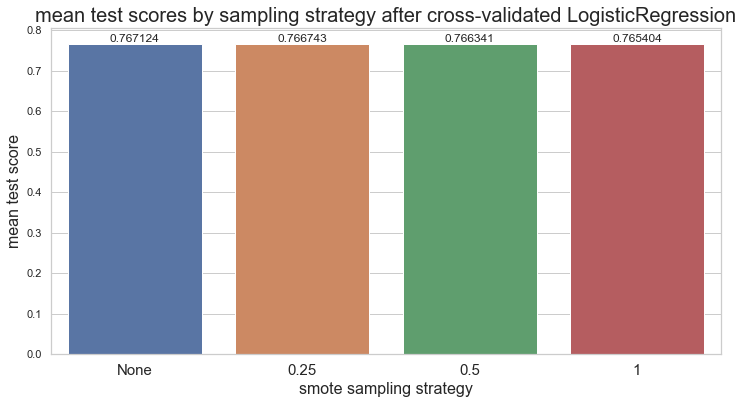

In [27]:
# Plot mean test scores by param_smote__sampling_strategy
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.set_theme(style="whitegrid")

g = sns.barplot(x = 'param_smote__sampling_strategy',
                y = 'mean_test_score',
                data = df_lr_smote,
                order = ['None', 0.25, 0.5, 1])

# Show exact mean_test_score for each sampling strategy
for i in g.containers:
    g.bar_label(i,)

plt.title('mean test scores by sampling strategy after cross-validated LogisticRegression',
          size = 20)
plt.xticks(size = 15)
plt.xlabel('smote sampling strategy', size = 16)
plt.ylabel('mean test score', size = 16)

plt.show()

### Conclusions for Logistic Regression
- Oversampling the minority class does not affect the roc_auc score
- Logistic Regression gives slightly better results (roc_auc = 0.767) compared to SGDClassifier (roc_auc = 0.763)

### Linear SVM

In [ ]:
# Linear SVM with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LinearSVC(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_svc_default = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)


gs_svc_default.fit(X, y)

cv_score_svc_default = gs_svc_default.best_score_
print('cv_score_svc_default:', cv_score_svc_default)

cv_results_svc_default = gs_svc_default.cv_results_
df_svc_default = pd.DataFrame(cv_results_svc_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

In [30]:
# Print results
df_svc_default

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,357.524357,15.09167,0.857372,0.167345,{},0.689259,0.718707,0.701886,0.712119,0.723908,0.709176,0.012381,1,0.700486,0.722461,0.709998,0.713075,0.729024,0.715009,0.009917


### Conclusions for LinearSVM
- Results are not as good as Logistic Regression with default parameters
- Fit time is higher compared to Logistic Regression  

-> There is no need to try different parameters and smote oversampling

### Gaussian Naive Bayes

In [31]:
# GaussianNB with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', GaussianNB()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_nb_default = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)


gs_nb_default.fit(X, y)

cv_score_nb_default = gs_nb_default.best_score_
print('cv_score_nb_default:', cv_score_nb_default)

cv_results_nb_default = gs_nb_default.cv_results_
df_nb_default = pd.DataFrame(cv_results_nb_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.517, test=0.516) total time=  11.6s
[CV 2/5] END ..............., score=(train=0.517, test=0.516) total time=  11.7s
[CV 3/5] END ..............., score=(train=0.516, test=0.512) total time=  10.7s
[CV 4/5] END ..............., score=(train=0.517, test=0.514) total time=   9.1s
[CV 5/5] END ..............., score=(train=0.518, test=0.517) total time=   9.5s
cv_score_nb_default: 0.5150010733155233
Execution time in seconds: 86.00476408004761
Execution time in minutes: 1.43341273466746


In [32]:
# GaussianNB with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', GaussianNB()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Test different parameters
param_grid = {'classifier__var_smoothing' : [1e-10, 1e-9, 1e-8, 1e-7]}

gs_nb = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_nb.fit(X, y)

cv_score_nb = gs_nb.best_score_
print('cv_score_nb:', cv_score_nb)

cv_results_nb = gs_nb.cv_results_
df_nb = pd.DataFrame(cv_results_nb)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier__var_smoothing=1e-10;, score=(train=0.515, test=0.514) total time=   8.4s
[CV 2/5] END classifier__var_smoothing=1e-10;, score=(train=0.515, test=0.513) total time=   9.8s
[CV 3/5] END classifier__var_smoothing=1e-10;, score=(train=0.515, test=0.511) total time=   9.1s
[CV 4/5] END classifier__var_smoothing=1e-10;, score=(train=0.515, test=0.512) total time=   8.5s
[CV 5/5] END classifier__var_smoothing=1e-10;, score=(train=0.517, test=0.515) total time=   8.5s
[CV 1/5] END classifier__var_smoothing=1e-09;, score=(train=0.517, test=0.516) total time=   8.3s
[CV 2/5] END classifier__var_smoothing=1e-09;, score=(train=0.517, test=0.516) total time=   8.0s
[CV 3/5] END classifier__var_smoothing=1e-09;, score=(train=0.516, test=0.512) total time=   8.9s
[CV 4/5] END classifier__var_smoothing=1e-09;, score=(train=0.517, test=0.514) total time=   8.5s
[CV 5/5] END classifier__var_smoothing=1e-09;, score=(trai

### Conclusions for Gaussian Naive Bayes
- roc auc scores are similar to random classifier
- changing var_smoothing does not affect auc roc score

### KNeighborsClassifier

-> Too long with this dataset (+ 300 000 customers)

### RandomForestClassifier

In [35]:
# RandomForestClassifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', RandomForestClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_rfc = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_rfc.fit(X, y)

cv_score_rfc = gs_rfc.best_score_
print('cv_score_rfc:', cv_score_rfc)

cv_results_rfc = gs_rfc.cv_results_
df_rfc = pd.DataFrame(cv_results_rfc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=1.000, test=0.713) total time= 4.8min
[CV 2/5] END ..............., score=(train=1.000, test=0.714) total time= 4.8min
[CV 3/5] END ..............., score=(train=1.000, test=0.714) total time= 4.6min
[CV 4/5] END ..............., score=(train=1.000, test=0.715) total time= 4.8min
[CV 5/5] END ..............., score=(train=1.000, test=0.708) total time= 4.8min
cv_score_rfc: 0.7128188334443053
Execution time in seconds: 1867.6822774410248
Execution time in minutes: 31.12803795735041


-> Fit time is too long compared to lgbmclassifier

### MLPClassifier

In [36]:
# MLPClassifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', MLPClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_mlpc = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_mlpc.fit(X, y)

cv_score_mlpc = gs_mlpc.best_score_
print('cv_score_mlpc:', cv_score_mlpc)

cv_results_mlpc = gs_mlpc.cv_results_
df_mlpc = pd.DataFrame(cv_results_mlpc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.977, test=0.654) total time=18.6min
[CV 2/5] END ..............., score=(train=0.978, test=0.657) total time=18.4min
[CV 3/5] END ..............., score=(train=0.977, test=0.653) total time=18.3min
[CV 4/5] END ..............., score=(train=0.975, test=0.652) total time=18.4min
[CV 5/5] END ..............., score=(train=0.978, test=0.657) total time=18.4min
cv_score_mlpc: 0.6546060588911886
Execution time in seconds: 6939.398977994919
Execution time in minutes: 115.65664963324865


-> Fit time is too long compared to lgbmclassifier

-> roc auc scores are lower than lgbmclassifier

### DecisionTreeClassifier

In [37]:
# DecisionTreeClassifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', DecisionTreeClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_dtc = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_dtc.fit(X, y)

cv_score_dtc = gs_dtc.best_score_
print('cv_score_dtc:', cv_score_dtc)

cv_results_dtc = gs_dtc.cv_results_
df_dtc = pd.DataFrame(cv_results_dtc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=1.000, test=0.540) total time= 2.4min
[CV 2/5] END ..............., score=(train=1.000, test=0.539) total time= 2.3min
[CV 3/5] END ..............., score=(train=1.000, test=0.544) total time= 2.3min
[CV 4/5] END ..............., score=(train=1.000, test=0.540) total time= 2.3min
[CV 5/5] END ..............., score=(train=1.000, test=0.544) total time= 2.2min
cv_score_dtc: 0.541090622093885
Execution time in seconds: 876.2474131584167
Execution time in minutes: 14.60412355264028


-> roc auc scores are lower than lgbmclassifier and similar to dummyclassifier

### lgbm Classifier

In [38]:
# LGBMClassifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_lgbm = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_lgbm.fit(X, y)

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbm = pd.DataFrame(cv_results_lgbm)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.828, test=0.776) total time=  19.1s
[CV 2/5] END ..............., score=(train=0.828, test=0.779) total time=  22.1s
[CV 3/5] END ..............., score=(train=0.827, test=0.780) total time=  22.9s
[CV 4/5] END ..............., score=(train=0.828, test=0.778) total time=  22.0s
[CV 5/5] END ..............., score=(train=0.829, test=0.774) total time=  23.9s
cv_score_lgbm: 0.7772326334570933
Execution time in seconds: 146.66703057289124
Execution time in minutes: 2.4444505095481874


In [42]:
# LGBMClassifier with scaler/classifier pipeline (no oversampling)
# Test different parameters
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {'classifier__boosting_type': ['gbdt', 'rf'],
              'classifier__n_estimators': [100, 500],
              'classifier__num_leaves': [31, 50],
              'classifier__max_depth ': [-1, 10]}

gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

gs_lgbm.fit(X, y)

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbm = pd.DataFrame(cv_results_lgbm)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__boosting_type=gbdt, classifier__max_depth =-1, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=0.828, test=0.776) total time= 1.5min
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: -1
[CV 2/5] END classifier__boosting_type=gbdt, classifier__max_depth =-1, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=0.828, test=0.779) total time= 1.5min
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: -1
[CV 3/5] END classifier__boosting_type=gbdt, classifier__max_depth =-1, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=0.827, test=0.780) total time= 1.2min
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warn

[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[CV 2/5] END classifier__boosting_type=gbdt, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=50;, score=(train=0.857, test=0.779) total time=  57.8s
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[CV 3/5] END classifier__boosting_type=gbdt, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=50;, score=(train=0.857, test=0.779) total time= 1.1min
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[CV 4/5] END classifier__boosting_type=gbdt, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=50;, score=(train=0.858, test=0.773) total time= 1.9min
[LightGBM] [Warning] max_depth is 

[CV 2/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=nan, test=nan) total time= 1.1min
[CV 3/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=nan, test=nan) total time= 1.1min
[CV 4/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=nan, test=nan) total time=  55.3s
[CV 5/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=31;, score=(train=nan, test=nan) total time= 1.2min
[CV 1/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=50;, score=(train=nan, test=nan) total time=  55.2s
[CV 2/5] END classifier__boosting_type=rf, classifier__max_depth =10, classifier__n_estimators=100, classifier__num_leaves=50

In [44]:
df_lgbm = df_lgbm.loc[df_lgbm['param_classifier__boosting_type'] == 'gbdt']
df_lgbm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__boosting_type,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,76.774676,10.144031,1.281023,0.280846,gbdt,-1,100,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775561,...,0.777233,0.002445,1,0.827594,0.827602,0.827243,0.827620,0.828868,0.827785,0.000559
1,87.625736,9.236925,1.181088,0.398858,gbdt,-1,100,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.776688,...,0.776038,0.002622,5,0.859007,0.856854,0.856841,0.857505,0.857109,0.857463,0.000809
2,85.391586,1.214668,1.009466,0.125567,gbdt,-1,500,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775627,...,0.776355,0.002326,3,0.936513,0.936243,0.935089,0.935231,0.937793,0.936174,0.000980
3,106.705204,13.870830,1.341748,0.106754,gbdt,-1,500,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.773320,...,0.772917,0.002327,7,0.973519,0.971643,0.972874,0.972853,0.974478,0.973073,0.000928
4,70.190327,1.908959,2.194874,2.518131,gbdt,10,100,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775561,...,0.777233,0.002445,1,0.827594,0.827602,0.827243,0.827620,0.828868,0.827785,0.000559
5,73.985307,19.218128,0.966830,0.070459,gbdt,10,100,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.776688,...,0.776038,0.002622,5,0.859007,0.856854,0.856841,0.857505,0.857109,0.857463,0.000809
6,87.178258,8.609127,1.175491,0.176146,gbdt,10,500,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775627,...,0.776355,0.002326,3,0.936513,0.936243,0.935089,0.935231,0.937793,0.936174,0.000980
7,106.291065,16.973315,1.322440,0.055872,gbdt,10,500,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.773320,...,0.772917,0.002327,7,0.973519,0.971643,0.972874,0.972853,0.974478,0.973073,0.000928


In [45]:
# Sort values by 'mean_test_score'
df_lgbm.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__boosting_type,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__num_leaves,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,76.774676,10.144031,1.281023,0.280846,gbdt,-1,100,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775561,...,0.777233,0.002445,1,0.827594,0.827602,0.827243,0.827620,0.828868,0.827785,0.000559
4,70.190327,1.908959,2.194874,2.518131,gbdt,10,100,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775561,...,0.777233,0.002445,1,0.827594,0.827602,0.827243,0.827620,0.828868,0.827785,0.000559
2,85.391586,1.214668,1.009466,0.125567,gbdt,-1,500,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775627,...,0.776355,0.002326,3,0.936513,0.936243,0.935089,0.935231,0.937793,0.936174,0.000980
6,87.178258,8.609127,1.175491,0.176146,gbdt,10,500,31,"{'classifier__boosting_type': 'gbdt', 'classif...",0.775627,...,0.776355,0.002326,3,0.936513,0.936243,0.935089,0.935231,0.937793,0.936174,0.000980
1,87.625736,9.236925,1.181088,0.398858,gbdt,-1,100,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.776688,...,0.776038,0.002622,5,0.859007,0.856854,0.856841,0.857505,0.857109,0.857463,0.000809
5,73.985307,19.218128,0.966830,0.070459,gbdt,10,100,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.776688,...,0.776038,0.002622,5,0.859007,0.856854,0.856841,0.857505,0.857109,0.857463,0.000809
3,106.705204,13.870830,1.341748,0.106754,gbdt,-1,500,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.773320,...,0.772917,0.002327,7,0.973519,0.971643,0.972874,0.972853,0.974478,0.973073,0.000928
7,106.291065,16.973315,1.322440,0.055872,gbdt,10,500,50,"{'classifier__boosting_type': 'gbdt', 'classif...",0.773320,...,0.772917,0.002327,7,0.973519,0.971643,0.972874,0.972853,0.974478,0.973073,0.000928


In [46]:
# Print best parameters
gs_lgbm.best_params_

{'classifier__boosting_type': 'gbdt',
 'classifier__max_depth ': -1,
 'classifier__n_estimators': 100,
 'classifier__num_leaves': 31}

-> Parameters by default are the best parameters

In [ ]:
# LGBMClassifier with scaler/classifier pipeline (no oversampling)
# Test different boosting_type
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Test different boosting types
param_grid = {'classifier__boosting_type': ['gbdt', 'dart', 'goss', 'rf']}

gs_lgbm_btype = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)

gs_lgbm_btype.fit(X, y)

cv_score_lgbm_btype = gs_lgbm_btype.best_score_
print('cv_score_lgbm_btype:', cv_score_lgbm_btype)

cv_results_lgbm_btype = gs_lgbm_btype.cv_results_
df_lgbm_btype = pd.DataFrame(cv_results_lgbm_btype)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

In [51]:
df_lgbm_btype = df_lgbm_btype.loc[df_lgbm_btype['param_classifier__boosting_type'] != 'rf']
df_lgbm_btype.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,89.862099,6.784751,1.271286,0.211607,gbdt,{'classifier__boosting_type': 'gbdt'},0.775561,0.779344,0.780204,0.777526,0.773529,0.777233,0.002445,1,0.827594,0.827602,0.827243,0.827620,0.828868,0.827785,0.000559
2,83.878140,7.761206,1.278689,0.405300,goss,{'classifier__boosting_type': 'goss'},0.774574,0.776902,0.775692,0.771569,0.770384,0.773824,0.002468,2,0.828212,0.827602,0.825518,0.827445,0.828464,0.827448,0.001036
1,94.094181,11.448091,1.072989,0.172574,dart,{'classifier__boosting_type': 'dart'},0.754581,0.759887,0.758192,0.756103,0.753400,0.756433,0.002356,3,0.776610,0.776687,0.775951,0.776281,0.776993,0.776504,0.000358


-> 'gbdt' boosting type gives the best roc auc score

### Evaluate best model (lgbmclassifier) with custom loss function

In [8]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

# Define business_cost_function : False negatives lead to more losses (10 times) than false positives 
def business_cost_func(y_true, y_pred):
    # Build confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)    
    # Define false positives (FP) and false negatives (FN)
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    # Define business cost function
    cost = (10 * FN + FP) / y_true.size

    return cost

# Create 'business_cost_loss' metric with make_scorer
business_cost_loss = make_scorer(business_cost_func, 
                                 greater_is_better = False) # False because it is a loss function

In [64]:
# LGBMClassifier with classifier pipeline (no oversampling)
# Using best parameters (found with roc_auc scoring)
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_lgbm_cost = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = business_cost_loss, # Using custom metric
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

gs_lgbm_cost.fit(X, y)

cv_score_lgbm_cost = gs_lgbm_cost.best_score_
print('cv_score_lgbm_cost:', cv_score_lgbm_cost)

cv_results_lgbm_cost = gs_lgbm_cost.cv_results_
df_lgbm_cost = pd.DataFrame(cv_results_lgbm_cost)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ............., score=(train=-0.766, test=-0.781) total time=  30.6s
[CV 2/5] END ............., score=(train=-0.770, test=-0.780) total time=  55.2s
[CV 3/5] END ............., score=(train=-0.766, test=-0.783) total time= 1.0min
[CV 4/5] END ............., score=(train=-0.769, test=-0.778) total time=  48.4s
[CV 5/5] END ............., score=(train=-0.765, test=-0.785) total time=  38.7s
cv_score_lgbm_cost: -0.7815139227492167
Execution time in seconds: 280.15943670272827
Execution time in minutes: 4.6693239450454715


In [65]:
# LGBMClassifier with smote/classifier pipeline
# Using best parameters (found with roc_auc scoring)
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1]}

gs_lgbm_cost_smote = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = business_cost_loss, # Using custom metric
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

gs_lgbm_cost_smote.fit(X, y)

cv_score_lgbm_cost_smote = gs_lgbm_cost_smote.best_score_
print('cv_score_lgbm_cost_smote:', cv_score_lgbm_cost_smote)

cv_results_lgbm_cost_smote = gs_lgbm_cost_smote.cv_results_
df_lgbm_cost_smote = pd.DataFrame(cv_results_lgbm_cost_smote)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END smote__sampling_strategy=0.25;, score=(train=-0.779, test=-0.787) total time= 1.3min
[CV 2/5] END smote__sampling_strategy=0.25;, score=(train=-0.778, test=-0.784) total time= 1.3min
[CV 3/5] END smote__sampling_strategy=0.25;, score=(train=-0.778, test=-0.784) total time= 1.2min
[CV 4/5] END smote__sampling_strategy=0.25;, score=(train=-0.778, test=-0.785) total time= 1.7min
[CV 5/5] END smote__sampling_strategy=0.25;, score=(train=-0.776, test=-0.787) total time= 1.4min
[CV 1/5] END smote__sampling_strategy=0.5;, score=(train=-0.781, test=-0.787) total time= 1.4min
[CV 2/5] END smote__sampling_strategy=0.5;, score=(train=-0.782, test=-0.783) total time= 1.2min
[CV 3/5] END smote__sampling_strategy=0.5;, score=(train=-0.783, test=-0.785) total time= 1.2min
[CV 4/5] END smote__sampling_strategy=0.5;, score=(train=-0.781, test=-0.787) total time= 2.3min
[CV 5/5] END smote__sampling_strategy=0.5;, score=(train=-0.78

In [66]:
df_lgbm_cost_smote.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,82.519159,8.758281,0.779503,0.034022,0.25,{'smote__sampling_strategy': 0.25},-0.787178,-0.784397,-0.784280,-0.784524,-0.787158,-0.785507,0.001358,1,-0.778992,-0.777899,-0.777729,-0.777766,-0.776046,-0.777686,0.000943
1,92.433373,24.574308,0.934624,0.134476,0.5,{'smote__sampling_strategy': 0.5},-0.787308,-0.783015,-0.784995,-0.787174,-0.786914,-0.785881,0.001660,2,-0.781200,-0.781728,-0.782583,-0.781473,-0.779753,-0.781347,0.000922
2,173.697789,97.475530,1.324399,0.080901,1,{'smote__sampling_strategy': 1},-0.787958,-0.785682,-0.786768,-0.782735,-0.788085,-0.786246,0.001961,3,-0.780590,-0.782078,-0.780583,-0.781416,-0.780965,-0.781126,0.000565


### Bayesian optimization by using hyperopt

In [54]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score

In [69]:
# Use Hyperopt
space = {'n_estimators': hp.quniform('n_estimators', 10, 1000, 10),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'num_leaves': hp.quniform('num_leaves', 20, 80, 2),
         'max_depth': hp.quniform('max_depth', 3, 10, 1),
         'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.95),
         'subsample': hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 0.01, 1)}

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
             'max_depth': int(params['max_depth']),
              'feature_fraction': params['feature_fraction'],
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'reg_lambda': params['reg_lambda']}
    
    lgbm = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5,
                         shuffle = True,
                         random_state = 11)
    score = cross_val_score(lgbm, 
                            X, y, 
                            scoring = 'roc_auc', 
                            cv = cv).mean()
    return -score

def objective_2(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
             'max_depth': int(params['max_depth']),
              'feature_fraction': params['feature_fraction'],
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'reg_lambda': params['reg_lambda']}
    
    lgbm = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5,
                         shuffle = True,
                         random_state = 11)
    score = cross_val_score(lgbm, 
                            X, y, 
                            scoring = business_cost_loss, 
                            cv = cv).mean()
    return -score

In [68]:
best = fmin(fn = objective, 
            space = space, 
            max_evals = 10, 
            rstate = np.random.default_rng(1), 
            algo = tpe.suggest)

[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9259355257031194, colsample_bytree=0.716851304248539 will be ignored. Current value: feature_fraction=0.9259355257031194
[LightGBM] [Warning] feature_fraction is set=0.9259355257031194, colsample_bytree=0.716851304248539 will be ignored. Current value: feature_fraction=0.92593

100%|██████████| 10/10 [52:41<00:00, 316.19s/trial, best loss: -0.7835487411298983]


In [72]:
best

{'colsample_bytree': 0.7940155098266799,
 'feature_fraction': 0.8179734610110364,
 'learning_rate': 0.021543053139697572,
 'max_depth': 8.0,
 'n_estimators': 870.0,
 'num_leaves': 74.0,
 'reg_lambda': 0.876671037651856,
 'subsample': 0.9012449573296004}

In [70]:
best_2 = fmin(fn = objective_2, 
            space = space, 
            max_evals = 10, 
            rstate = np.random.default_rng(1), 
            algo = tpe.suggest)

[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=0.8823365667875521 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9259355257031194, colsample_bytree=0.716851304248539 will be ignored. Current value: feature_fraction=0.9259

[LightGBM] [Warning] feature_fraction is set=0.6810901947834207, colsample_bytree=0.6434517583880242 will be ignored. Current value: feature_fraction=0.6810901947834207
100%|██████████| 10/10 [39:45<00:00, 238.58s/trial, best loss: 0.7622623261488006]


In [73]:
best_2

{'colsample_bytree': 0.6913059478717032,
 'feature_fraction': 0.6962768623738181,
 'learning_rate': 0.18856082240104088,
 'max_depth': 9.0,
 'n_estimators': 990.0,
 'num_leaves': 20.0,
 'reg_lambda': 0.8840847437899272,
 'subsample': 0.8108805965092771}

In [75]:
from sklearn.model_selection import train_test_split

# Train_test_split 80/20 with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [76]:
lgbm = LGBMClassifier(n_estimators = int(best_2['n_estimators']),
                      learning_rate = best_2['learning_rate'],
                      num_leaves = int(best_2['num_leaves']),
                      max_depth = int(best_2['max_depth']),
                      feature_fraction = best_2['feature_fraction'],
                      subsample = best_2['subsample'],
                      colsample_bytree = best_2['colsample_bytree'],
                      reg_lambda = best_2['reg_lambda'],
                      random_state = 11,
                      verbosity = 5)

lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6962768623738181, colsample_bytree=0.6913059478717032 will be ignored. Current value: feature_fraction=0.6962768623738181
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6962768623738181, colsample_bytree=0.6913059478717032 will be ignored. Current value: feature_fraction=0.6962768623738181
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.910579
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.550256
[LightGBM] [Debug] init for col-wise cost 0.100521 seconds, init for row-wise cost 0.278104 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55364
[LightGBM] [Info] Number of data points in the train 

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Traine

LGBMClassifier(colsample_bytree=0.6913059478717032,
               feature_fraction=0.6962768623738181,
               learning_rate=0.18856082240104088, max_depth=9, n_estimators=990,
               num_leaves=20, random_state=11, reg_lambda=0.8840847437899272,
               subsample=0.8108805965092771, verbosity=5)

In [79]:
from sklearn.metrics import auc,roc_curve
def plot_roc(pred):
    fpr,tpr,_ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    sns.lineplot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

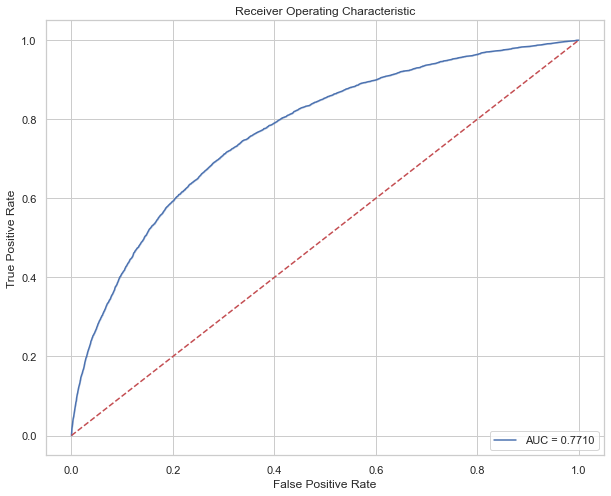

In [80]:
lgbm_opt = lgbm.predict_proba(X_test)[:,1]
plot_roc(lgbm_opt)

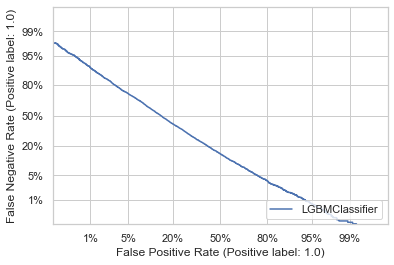

In [82]:
from sklearn.metrics import plot_det_curve
plot_det_curve(lgbm, X_test, y_test)
plt.show()

In [ ]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary_thres = (lgbm.predict_proba(X_test)[:,1] >= threshold).astype(bool)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary_thres))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary_thres)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (5,4))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

business_cost_func(y_true, y_pred)

In [85]:
def calculate_business_cost(X_test, y_test, model, threshold):
    # Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
    y_pred_binary_thres = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

    # Print classification report with precision, recall and f1-score for each class
    from sklearn.metrics import classification_report
    print('classification_report :')
    print(' ')
    print(classification_report(y_test, y_pred_binary_thres))

    # Print Confusion Matrix on Test data
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_test, y_pred_binary_thres)
    data_cm = pd.DataFrame(conf_mat,
                           index = ['can repay', 'can not repay'],
                           columns = ['can repay', 'can not repay'])

    plt.figure(figsize = (5,4))
    cmap = 'YlOrBr'
    colormap = sns.heatmap(data_cm, 
                            annot=True, 
                            annot_kws ={'size':14}, 
                            cmap=cmap, 
                            fmt='.3g')
    colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
    colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
    colormap.set(xlabel = 'predicted label',
                 ylabel = 'true label',
                 title = 'Confusion Matrix test data')

    print('business_cost =', business_cost_func(y_test, y_pred_binary_thres))

classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56537
         1.0       0.48      0.07      0.12      4965

    accuracy                           0.92     61502
   macro avg       0.70      0.53      0.54     61502
weighted avg       0.89      0.92      0.89     61502

business_cost = 0.7602191798640695


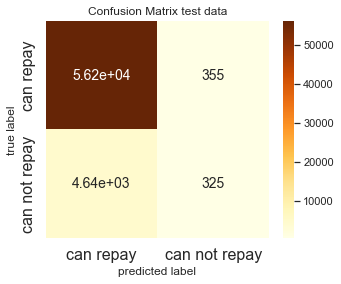

In [86]:
calculate_business_cost(X_test, y_test, lgbm, 0.5)

In [101]:
def return_business_cost(X_test, y_test, model, threshold):
    y_pred_binary_thres = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

    return business_cost_func(y_test, y_pred_binary_thres)

In [239]:
# Calculate business_cost for different threshold from 0 to 1
threshold_list = np.arange(0, 1, 0.01)
business_cost = []

for thresh in threshold_list:
    y_pred_binary_thres = (lgbm.predict_proba(X_test)[:,1] >= thresh).astype(int)
    cost = business_cost_func(y_test, y_pred_binary_thres)
    business_cost.append(cost)

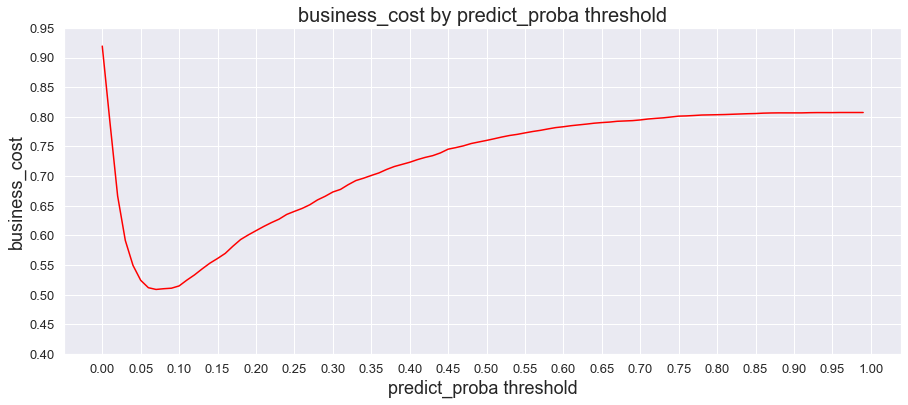

In [281]:
import matplotlib.pyplot as plt

sns.set_theme()

fig = plt.figure(figsize = (15,6))
ax = fig.subplots()
ax.plot(threshold_list, business_cost, color = 'red', label = 'business_cost')

plt.xlabel("predict_proba threshold", size = 18)
plt.ylabel("business_cost", size = 18)
plt.xticks(np.arange(0, 1.01, step = 0.05), size = 13)
plt.yticks(np.arange(0.4, 1, step = 0.05), size = 13)
plt.title("business_cost by predict_proba threshold", size = 20)

plt.show()

In [292]:
# Print minimum business cost value and argmin threshold value
print('minimum business_cost value:', np.min(business_cost))
print('argmin threshold value:', threshold_list[np.argmin(business_cost)])

minimum business_cost value: 0.5089102793405093
argmin threshold value: 0.07


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56537
         1.0       0.18      0.68      0.29      4965

    accuracy                           0.73     61502
   macro avg       0.57      0.70      0.56     61502
weighted avg       0.90      0.73      0.79     61502

business_cost = 0.5089102793405093


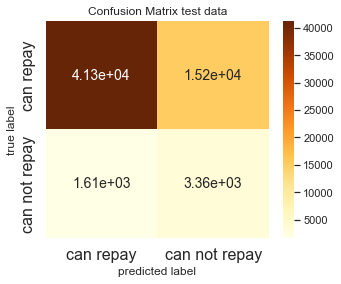

In [293]:
# Display classification report and confusion matrix for minimum business cost
calculate_business_cost(X_test, y_test, lgbm, 0.07)

### GradientBoostingClassifier

In [39]:
# GradientBoostingClassifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', GradientBoostingClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_gbc = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 5,
                              return_train_score = True)

gs_gbc.fit(X, y)

cv_score_gbc = gs_gbc.best_score_
print('cv_score_gbc:', cv_score_gbc)

cv_results_gbc = gs_gbc.cv_results_
df_gbc = pd.DataFrame(cv_results_gbc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.779, test=0.766) total time=14.2min
[CV 2/5] END ..............., score=(train=0.778, test=0.772) total time=14.2min
[CV 3/5] END ..............., score=(train=0.778, test=0.771) total time=14.3min
[CV 4/5] END ..............., score=(train=0.779, test=0.766) total time=14.4min
[CV 5/5] END ..............., score=(train=0.779, test=0.765) total time=14.4min
cv_score_gbc: 0.7680923508435231
Execution time in seconds: 5415.859104394913
Execution time in minutes: 90.26431840658188


-> Fit time is too long compared to lgbmclassifier

### XGBoost

In [41]:
# XGBoost with scaler/classifier pipeline (no oversampling)
# Using default parameters
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', XGBClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_xgb = GridSearchCV(estimator = pipeline,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                              cv = stratified_kfold,
                              verbose = 2,
                              return_train_score = True)

gs_xgb.fit(X, y)

cv_score_xgb = gs_xgb.best_score_
print('cv_score_xgb:', cv_score_xgb)

cv_results_xgb = gs_xgb.cv_results_
df_xgb = pd.DataFrame(cv_results_xgb)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time= 2.8min
[CV] END .................................................... total time= 2.8min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.8min
cv_score_xgb: 0.7691946972617738
Execution time in seconds: 1049.0799186229706
Execution time in minutes: 17.484665310382844


## Conclusion
- lgbm classifier is the best model
- lgbm classifier can handle with NaN values  

-> Consequently, initial dataframe will be used to optimize the model

# Optimize final lgbm classifier model

In [3]:
train_df = pd.read_csv('train_df.csv')

In [4]:
# remove special characters in train_df feature names
train_df.columns = train_df.columns.str.replace(':', '')
train_df.columns = train_df.columns.str.replace(',', '')
train_df.columns = train_df.columns.str.replace(']', '')
train_df.columns = train_df.columns.str.replace('[', '')
train_df.columns = train_df.columns.str.replace('{', '')
train_df.columns = train_df.columns.str.replace('}', '')
train_df.columns = train_df.columns.str.replace('"', '')

In [5]:
# Create X (features matrix) and y (Target) from train_df_nan40
X = train_df.drop(['index', 'SK_ID_CURR', 'TARGET'], 1)
y = train_df.TARGET

### Bayesian optimization by using hyperopt

In [6]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use Hyperopt
space = {'n_estimators': hp.quniform('n_estimators', 10, 5000, 10),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'num_leaves': hp.quniform('num_leaves', 20, 80, 2),
         'max_depth': hp.quniform('max_depth', 3, 10, 1),
         'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.95),
         'subsample': hp.uniform('subsample', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 0.01, 1)}

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
             'max_depth': int(params['max_depth']),
              'feature_fraction': params['feature_fraction'],
             'subsample': params['subsample'],
             'reg_lambda': params['reg_lambda']}
    
    lgbm = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5,
                         shuffle = True,
                         random_state = 11)
    score = cross_val_score(lgbm, 
                            X, y, 
                            scoring = 'roc_auc', 
                            cv = cv).mean()
    return -score

def objective_2(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
             'max_depth': int(params['max_depth']),
              'feature_fraction': params['feature_fraction'],
             'subsample': params['subsample'],
             'reg_lambda': params['reg_lambda']}
    
    lgbm = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5,
                         shuffle = True,
                         random_state = 11)
    score = cross_val_score(lgbm, 
                            X, y, 
                            scoring = business_cost_loss, 
                            cv = cv).mean()
    return -score

In [11]:
best_2 = fmin(fn = objective_2, 
            space = space, 
            max_evals = 20, 
            rstate = np.random.default_rng(1), 
            algo = tpe.suggest)

[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9275276350371613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275276350371613
[LightGBM] [Warning] feature_fraction is set=0.9259355257031194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259355257031194
[LightGBM] [Warning] feature_fraction is set=0.9259355257031194, colsample_b

In [13]:
best_2

{'feature_fraction': 0.804726710739277,
 'learning_rate': 0.13804458516717533,
 'max_depth': 5.0,
 'n_estimators': 1700.0,
 'num_leaves': 54.0,
 'reg_lambda': 0.9151517397680748,
 'subsample': 0.7791287584851807}

### Feature importance

In [12]:
# Feature importance
from sklearn.model_selection import cross_validate

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

lgbm = LGBMClassifier(n_estimators = int(best_2['n_estimators']),
                      learning_rate = best_2['learning_rate'],
                      num_leaves = int(best_2['num_leaves']),
                      max_depth = int(best_2['max_depth']),
                      feature_fraction = best_2['feature_fraction'],
                      subsample = best_2['subsample'],
                      reg_lambda = best_2['reg_lambda'],
                      random_state = 11,
                      verbosity = 5)

output = cross_validate(lgbm, 
                        X, y, 
                        cv = stratified_kfold, 
                        scoring = business_cost_loss, 
                        return_estimator = True)

[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.840263
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.533068
[LightGBM] [Debug] init for col-wise cost 0.173468 seconds, init for row-wise cost 0.660263 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.785643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99704
[LightGBM] [Info] Number of data points in the train set: 246005, number of used featur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tr

[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Info] Number of positive: 19860, number of negative: 226146
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.837591
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.541408
[LightGBM] [Debug] init for col-wise cost 0.149458 seconds, init for row-wise cost 0.659995 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.794779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99600
[LightGBM] [Info] Number of data points in the train set: 246006, number of used featur

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

In [19]:
output['estimator']

[LGBMClassifier(feature_fraction=0.804726710739277,
                learning_rate=0.13804458516717533, max_depth=5,
                n_estimators=1700, num_leaves=54, random_state=11,
                reg_lambda=0.9151517397680748, subsample=0.7791287584851807,
                verbosity=5),
 LGBMClassifier(feature_fraction=0.804726710739277,
                learning_rate=0.13804458516717533, max_depth=5,
                n_estimators=1700, num_leaves=54, random_state=11,
                reg_lambda=0.9151517397680748, subsample=0.7791287584851807,
                verbosity=5),
 LGBMClassifier(feature_fraction=0.804726710739277,
                learning_rate=0.13804458516717533, max_depth=5,
                n_estimators=1700, num_leaves=54, random_state=11,
                reg_lambda=0.9151517397680748, subsample=0.7791287584851807,
                verbosity=5),
 LGBMClassifier(feature_fraction=0.804726710739277,
                learning_rate=0.13804458516717533, max_depth=5,
              

In [21]:
output

{'fit_time': array([150.00115561, 139.39073777, 148.48251152, 155.4107554 ,
        143.06863308]),
 'score_time': array([3.33673716, 3.2307713 , 2.86196184, 2.83676505, 2.90567827]),
 'estimator': [LGBMClassifier(feature_fraction=0.804726710739277,
                 learning_rate=0.13804458516717533, max_depth=5,
                 n_estimators=1700, num_leaves=54, random_state=11,
                 reg_lambda=0.9151517397680748, subsample=0.7791287584851807,
                 verbosity=5),
  LGBMClassifier(feature_fraction=0.804726710739277,
                 learning_rate=0.13804458516717533, max_depth=5,
                 n_estimators=1700, num_leaves=54, random_state=11,
                 reg_lambda=0.9151517397680748, subsample=0.7791287584851807,
                 verbosity=5),
  LGBMClassifier(feature_fraction=0.804726710739277,
                 learning_rate=0.13804458516717533, max_depth=5,
                 n_estimators=1700, num_leaves=54, random_state=11,
                 reg_lambda

In [22]:
model_lgbm = lgbm.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.864352
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.590300
[LightGBM] [Debug] init for col-wise cost 0.235795 seconds, init for row-wise cost 0.962407 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.155622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99794
[LightGBM] [Info] Number of data points in the train set: 307507, number of used featur

[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

In [24]:
len(model_lgbm.feature_importances_)

795

In [9]:
from lightgbm import LGBMClassifier
# Feature importance
lgbm = LGBMClassifier(n_estimators = 1700,
                      learning_rate = 0.13804458516717533,
                      num_leaves = 54,
                      max_depth = 5,
                      feature_fraction = 0.804726710739277,
                      subsample = 0.7791287584851807,
                      reg_lambda = 0.9151517397680748,
                      random_state = 11,
                      verbosity = 5)

model_lgbm = lgbm.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.804726710739277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804726710739277
[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.864352
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.590300
[LightGBM] [Debug] init for col-wise cost 0.215988 seconds, init for row-wise cost 0.843167 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.044121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99794
[LightGBM] [Info] Number of data points in the train set: 307507, number of used featur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning]

In [12]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [13]:
shap_values = shap.TreeExplainer(model_lgbm).shap_values(X)

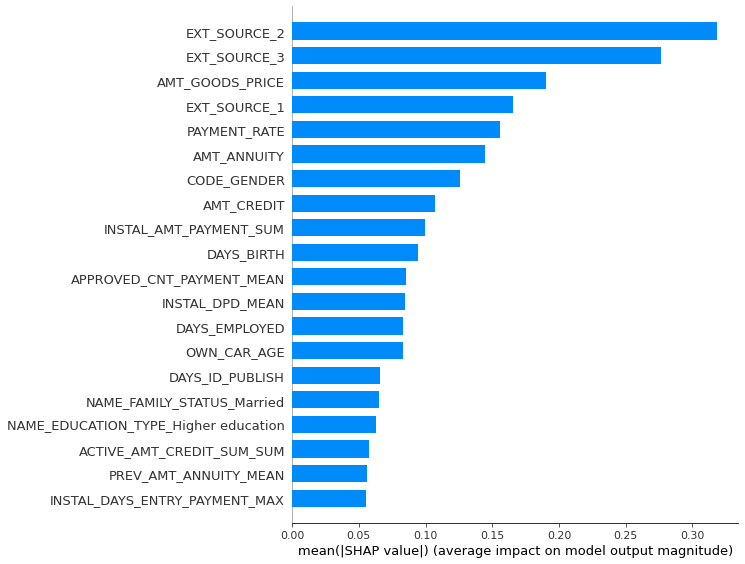

In [18]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values[0], X, plot_type = 'bar')

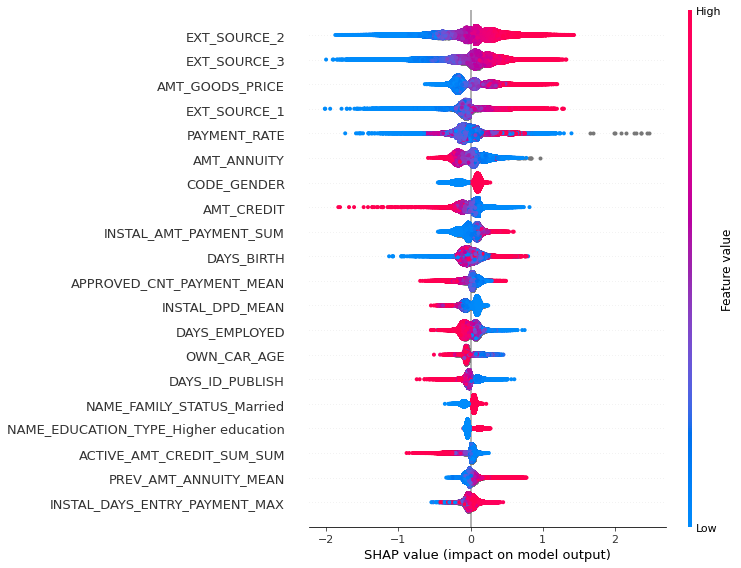

In [14]:
shap.summary_plot(shap_values[0], X)

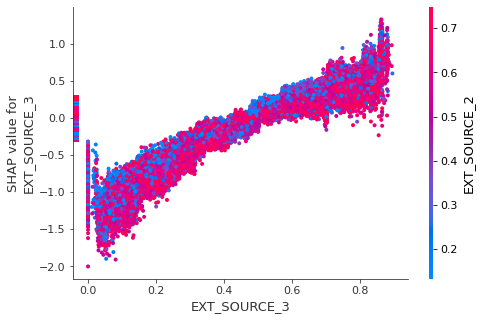

In [15]:
shap.dependence_plot("EXT_SOURCE_3", shap_values[0], X)

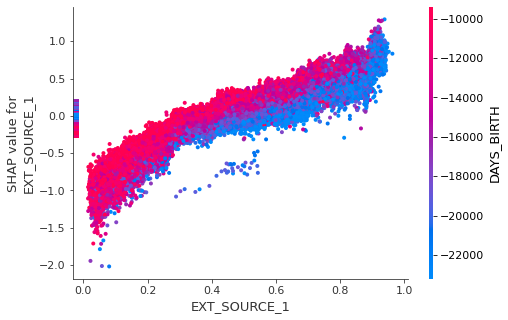

In [19]:
shap.dependence_plot("EXT_SOURCE_1", shap_values[0], X)

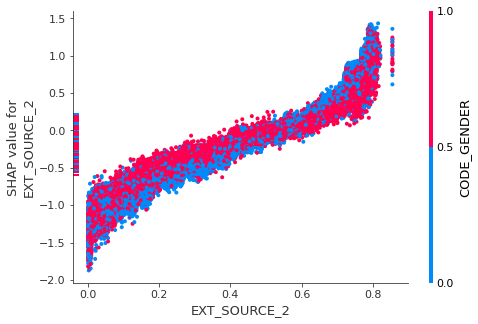

In [20]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[0], X)

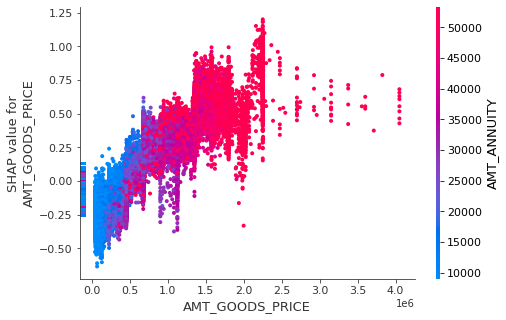

In [21]:
shap.dependence_plot("AMT_GOODS_PRICE", shap_values[0], X)

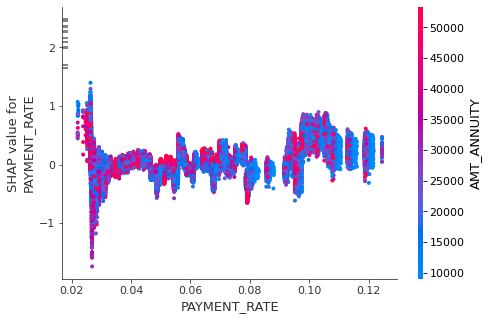

In [22]:
shap.dependence_plot("PAYMENT_RATE", shap_values[0], X)

In [23]:
shap_sum = np.abs(shap_values[0]).mean(axis = 0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending = False)
importance_df

,column_name,shap_importance
31,EXT_SOURCE_2,0.318544
32,EXT_SOURCE_3,0.276515
7,AMT_GOODS_PRICE,0.190367
30,EXT_SOURCE_1,0.165424
244,PAYMENT_RATE,0.15579
...,...,...
116,NAME_INCOME_TYPE_Businessman,0.0
112,NAME_TYPE_SUITE_Other_A,0.0
111,NAME_TYPE_SUITE_Group of people,0.0
342,CLOSED_CREDIT_DAY_OVERDUE_MAX,0.0


In [24]:
importance_df.head(20)

,column_name,shap_importance
31,EXT_SOURCE_2,0.318544
32,EXT_SOURCE_3,0.276515
7,AMT_GOODS_PRICE,0.190367
30,EXT_SOURCE_1,0.165424
244,PAYMENT_RATE,0.15579
6,AMT_ANNUITY,0.144874
0,CODE_GENDER,0.1255
5,AMT_CREDIT,0.106887
649,INSTAL_AMT_PAYMENT_SUM,0.099493
9,DAYS_BIRTH,0.093994


In [47]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values[0][0], X.iloc[0,:], plot_type = 'bar')

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [57]:
shap_values[0]

array([[-1.25237434e-01, -9.46871824e-03, -2.32617181e-03, ...,
         0.00000000e+00,  0.00000000e+00, -5.36340250e-07],
       [ 1.03601355e-01, -1.79076160e-03,  3.54210276e-03, ...,
         0.00000000e+00,  0.00000000e+00,  1.81299939e-03],
       [-2.63792688e-01,  8.14321130e-03, -5.32359223e-03, ...,
         0.00000000e+00,  0.00000000e+00,  3.23607654e-05],
       ...,
       [ 9.25434532e-02, -3.41940690e-03, -1.81572503e-03, ...,
         0.00000000e+00,  0.00000000e+00, -2.50984299e-05],
       [ 8.56197634e-02, -3.29589758e-03, -1.26530457e-03, ...,
         0.00000000e+00,  0.00000000e+00, -1.47355186e-04],
       [ 7.80958440e-02,  1.51503167e-05,  6.62648338e-03, ...,
         0.00000000e+00,  0.00000000e+00,  1.71441502e-03]])